In [14]:
def read_text(fname):
    fo=open(fname,'r') #create file object
    #headstr=fo.readline()
    data=fo.readlines()
    #print (data)
    fo.close()  # close object
    return data

# main
import os 
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import glob
from pyhdf.SD import SD, SDC
import h5py
#from pyproj import Geod
import scipy,scipy.ndimage
from shapely.geometry import Polygon

print('start',datetime.now())
#fnames=glob.glob('/data/keeling/a/yulanh/c/OT_output/2018/MODIS_OTinfo_2018116.0030.txt')
#'2000','2001','2002','2003','2004','2005','2006','2007',
#=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013',\
#       '2014','2015','2016','2017','2018','2019','2020']
years=['2021']#,'2019','2020']
#geod = Geod('+a=6378137 +f=0.0033528106647475126')
print(years)
for year in years:
    
    fnames=glob.glob('/data/keeling/a/yulanh/c/OT_output/Terra/'+year+'/*.txt')
    #fnames=glob.glob('/data/keeling/a/yulanh/c/OT_output/2018/MODIS_OTinfo_2018059.0135.txt')
    #hy5file='/data/keeling/a/yulanh/c/OT_climatology/MODIS_OTNOT_summary_polygon2_'+year+'.h5'
    hy5file='test.h5'
    NOTA=100 
    Nhetero=60 # bin0.005, 0-0.2
    hetero_bin=0.005
    NBTD_wv=100 # bin 0.25, 0-25 K
    wv_bin=0.25
    NBTD_ci=200 # bin 0.5, 0-60 K
    ci_bin=0.5
    NBTD_trop=200 # bin 0.5, 0-50K
    trop_bin=0.5
    NBT=90 #150-240
    bt_bin=1

    Nlon=360
    Nlat=180
    trop_prob_threshold=0.9
    mid_prob_threshold=0.9

    OT_map=np.zeros((360,180,12,2),'i') # 12 for month; #0 for day, 1 for night
    OTA_map=np.zeros((360,180,12,2),'f')
    OTA_poly_map=np.zeros((360,180,12,2),'f')
    OT_hetero_map=np.zeros((360,180,12,2),'f')

    OT_map_LP=np.zeros((360,180,12,2),'i') #0 for day, 1 for night
    OTA_map_LP=np.zeros((360,180,12,2),'f')
    OTA_poly_map_LP=np.zeros((360,180,12,2),'f')
    OT_hetero_map_LP=np.zeros((360,180,12,2),'f')

    OTA_pdf  =np.zeros((Nlat,NOTA,12,2),'i')
    OTA_poly_pdf  =np.zeros((Nlat,NOTA,12,2),'i')
    hetero_pdf=np.zeros((Nlat,Nhetero,12,2),'i')
    BTD_wv_pdf  =np.zeros((Nlat,NBTD_wv,12,2),'i')
    BTD_ci_pdf  =np.zeros((Nlat,NBTD_ci,12,2),'i')
    BTD_trop_pdf  =np.zeros((Nlat,NBTD_trop,12,2),'i')
    OTBT_pdf = np.zeros((Nlat,NBT,12,2),'i')

    OTA_LP_pdf=np.zeros((Nlat,NOTA,12,2),'i')
    OTA_poly_LP_pdf=np.zeros((Nlat,NOTA,12,2),'i')
    hetero_LP_pdf=np.zeros((Nlat,Nhetero,12,2),'i')
    BTD_wv_LP_pdf  =np.zeros((Nlat,NBTD_wv,12,2),'i')
    BTD_ci_LP_pdf  =np.zeros((Nlat,NBTD_ci,12,2),'i')
    BTD_trop_LP_pdf  =np.zeros((Nlat,NBTD_trop,12,2),'i')
    OTBT_LP_pdf = np.zeros((Nlat,NBT,12,2),'i')

    OTA_day_10_points=np.empty((0),'f') # record the data to get the mean, and std
    OTA_day_1025_points=np.empty((0),'f')
    OTA_day_2540_points=np.empty((0),'f')
    OTA_day_4060_points=np.empty((0),'f')
    OTA_night_10_points=np.empty((0),'f') # record the data to get the mean, and std
    OTA_night_1025_points=np.empty((0),'f')
    OTA_night_2540_points=np.empty((0),'f')
    OTA_night_4060_points=np.empty((0),'f')

    OTA_poly_day_10_points=np.empty((0),'f') # record the data to get the mean, and std
    OTA_poly_day_1025_points=np.empty((0),'f')
    OTA_poly_day_2540_points=np.empty((0),'f')
    OTA_poly_day_4060_points=np.empty((0),'f')
    OTA_poly_night_10_points=np.empty((0),'f') # record the data to get the mean, and std
    OTA_poly_night_1025_points=np.empty((0),'f')
    OTA_poly_night_2540_points=np.empty((0),'f')
    OTA_poly_night_4060_points=np.empty((0),'f')
    #OTA_night_points=[[],[],[]]
    #fnames=fnames[len(fnames)-10:len(fnames)-1]
    #fnames=['/data/keeling/a/yulanh/c/OT_output/Terra/2021/MODIS_OTinfo_2021191.2155.txt']
    
    for fname in fnames:

        file_size=os.path.getsize(fname)

        if (file_size ==0):
            os.system('rm '+fname)

        if (file_size > 0) :
            #print(fname,file_size)
            
            #get the radiance and geolocation file
            Julday=fname[-12:-9]
            yyyymmdd=fname[-16:-4] 
            mod03fname=glob.glob('/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/'+\
                                 year+'/'+Julday+'/MOD03.A'+yyyymmdd+'*')
            #mod03fname=glob.glob('/data/gdi/e/MODIS/MYD03/'+\
            #                     year+'/'+Julday+'/MYD03.A'+yyyymmdd+'*')
            print(mod03fname)
            hdf=SD(mod03fname[0])
            modlat=hdf.select('Latitude')
            modlat=modlat[:,:]
            modlon=hdf.select('Longitude')
            modlon=modlon[:,:]
            
            data=read_text(fname)
            splitcol=data[0].split(' ')
            Ncol=len(splitcol)-splitcol.count('')
            Nrow=len(data)

            #print(year_st,day_st)
            start_date=date(int(year),1,1)
            convt_date=start_date+timedelta(days=int(Julday)-1)
            date_res  = convt_date.strftime("%m-%d-%y")
            month_st=date_res[0:2]
            month_scp=int(month_st)-1
            #print(month_scp,month_st)
            #print(date_res)    
            # transfer data from string to float
            dataT=np.zeros((Nrow,Ncol),'f')
            for i in range(Nrow):
                splitcol=data[i].split(' ')
                k=0
                for j in range(len(splitcol)):
                    if splitcol[j] != '' and splitcol[j] != '\n' :

                        dataT[i,k]=float(splitcol[j])
                        k=k+1

            #print(dataT[0,:])
            #judge day and night

            # record data
            #lon_scp=np.round(dataT[:,2])
            #lat_scp=np.round(dataT[:,3])
            #OTA_scp=np.round(dataT[:,5])
            #print(dataT.shape)
            proba = dataT[:,4]

            for i in range(Nrow):
                tpOTA=dataT[i,5]
                BT11_minOT=dataT[i,6]
                BT11_aveOT=dataT[i,7]
                BT67_minOT=dataT[i,8]
                BT67_aveOT=dataT[i,9]
                trop_T = dataT[i,10]
                BT11_aveci=dataT[i,11]
                hetero= dataT[i,30]/((BT11_aveOT+BT11_aveci)/2.0)
                OTedge=dataT[i,20:28]
                xscp = dataT[i,0]
                yscp = dataT[i,1]
                #print(tpOTA,BT11_minOT,BT11_aveOT,BT67_minOT,BT67_aveOT,trop_T,BT11_aveci,hetero)
                data_process_flag=0
                
                #=== to calculate the OTA from polygon =====
                x0=yscp
                y0=xscp
                x1_all = [x0 + OTedge[0], x0 + OTedge[1]*np.cos(45*np.pi/180, dtype='d'), x0          , \
                      x0 - OTedge[3]*np.cos(45*np.pi/180, dtype='d'), x0 -OTedge[4]*np.cos(45*np.pi/180, dtype='d'), \
                      x0 -OTedge[5]*np.cos(45*np.pi/180, dtype='d'), x0                               , \
                      x0 + OTedge[7]*np.cos(45*np.pi/180, dtype='d')]
                y1_all = [y0            , y0 + OTedge[1]*np.cos(45*np.pi/180, dtype='f'), y0+OTedge[2], \
                      y0 + OTedge[3]*np.cos(45*np.pi/180, dtype='d'), y0                                 , \
                      y0 - OTedge[5]*np.cos(45*np.pi/180, dtype='d'), y0-OTedge[6]*np.cos(45*np.pi/180, dtype='d') , \
                      y0 -OTedge[7]*np.cos(45*np.pi/180, dtype='d')]

                #lats_bound= scipy.ndimage.map_coordinates(modlat, np.vstack((x1_all,y1_all)))
                #lons_bound= scipy.ndimage.map_coordinates(modlon, np.vstack((x1_all,y1_all)))
                
                #area, perim = geod.polygon_area_perimeter(lons_bound, lats_bound)
                #tpOTA_poly=np.abs(area)/1000000.0
                tpOTA_poly = Polygon(zip(x1_all,y1_all)).area
                #if np.isnan(tpOTA_poly):
                #    tpOTA_poly=np.nan_to_num(tpOTA_poly)
                #    print(fname,tpOTA_poly,dataT[i,5],OTedge)
                #if tpOTA_poly > 500:
                #    print(lats_bound,lons_bound)
                #    print(x1_all,y1_all)
                #    print(fname,tpOTA_poly,dataT[i,5],OTedge)
                    
                #print(tpOTA,tpOTA_poly)
    #lons[j]= scipy.ndimage.map_coordinates(mod_lon, np.vstack((x1,y1)))  
                if (proba[i] >= trop_prob_threshold and abs(dataT[i,3]) < 25 and BT11_minOT > 150):# and hetero > 0.04):
                    data_process_flag=1
                if (proba[i] >= trop_prob_threshold and abs(dataT[i,3]) >=25 and BT11_minOT > 150): # and hetero > 0.045):
                    data_process_flag=1

                if (proba[i] < trop_prob_threshold and abs(dataT[i,3]) < 25 and BT11_minOT > 150):# and hetero > 0.04):
                    data_process_flag=2
                if (proba[i] < trop_prob_threshold and abs(dataT[i,3]) >=25 and BT11_minOT > 150): # and hetero > 0.045):
                    data_process_flag=2

                lon_scp=round(dataT[i,2]+180)
                lat_scp=round(dataT[i,3]+90)
                OTA_scp=round(dataT[i,5]/10)
                OTA_poly_scp=round(tpOTA_poly/10)
                
                hetero_scp=round(hetero/hetero_bin)
                if (hetero_scp > Nhetero-1):
                    hetero_scp=Nhetero-1
                #print(BT67_aveOT,BT11_aveOT)
                BTD_wv_scp=round((BT67_aveOT-BT11_aveOT)/wv_bin)
                if (BTD_wv_scp > NBTD_wv-1):
                    BTD_wv_scp=NBTD_wv-1

                BTD_ci_scp=round((BT11_aveci-BT11_minOT)/ci_bin)
                if (BTD_ci_scp > NBTD_ci-1):
                    BTD_ci_scp=NBTD_ci-1

                BTD_trop_scp=round((trop_T-BT11_minOT)/trop_bin)
                if (BTD_trop_scp > NBTD_trop-1):
                    BTD_trop_scp=NBTD_trop-1

                BT_scp=round((BT11_minOT-150)/bt_bin)
                if (BT_scp > NBT-1):
                    BT_scp=NBT-1
                #print(hetero,hetero_scp)
             
                SLT=float(fname[-8:-6])+dataT[i,2]/15.0 #solar local time
                #print(fname[-8:-6],dataT[i,2], SLT)
                dnflag=0
                if (SLT < 0) :
                    SLT=SLT+24

                if (SLT > 24) :
                    SLT=SLT-24

                #if (SLT > 18) :
                #    dnflag=1
                #if ((SLT > 0) & (SLT < 6)):
                #    dnflag =1

                if ((SLT >= 6) & (SLT < 18)):
                    dnflag=0
                else:
                    dnflag=1
                
                if lon_scp > (Nlon-1):
                    lon_scp=Nlon-1     

                if lat_scp > (Nlat-1):
                    lat_scp=Nlat-1   

                if OTA_scp > (NOTA-1):
                    OTA_scp=NOTA-1
                    
                if OTA_poly_scp > (NOTA-1):
                    OTA_poly_scp=NOTA-1
                
                #print('dn flag',SLT,dnflag)
                #print(dataT[i,2],lon_scp,dataT[i,3],lat_scp,dnflag,month_scp,dataT[i,5],proba[i])
                #print(BT11_aveci,BT11_minOT,BTD_ci_scp,dataT[i,3],lat_scp,month_scp,dnflag)
                #print(data_process_flag,dnflag,dataT[i,3],dataT[i,4],dataT[i,5])
                if (data_process_flag == 2):
                    OT_map_LP[lon_scp,lat_scp,month_scp,dnflag]=OT_map_LP[lon_scp,lat_scp,month_scp,dnflag]+1
                    OTA_map_LP[lon_scp,lat_scp,month_scp,dnflag]=OTA_map_LP[lon_scp,lat_scp,month_scp,dnflag]+tpOTA_poly
                    OTA_poly_map_LP[lon_scp,lat_scp,month_scp,dnflag]=OTA_poly_map_LP[lon_scp,lat_scp,month_scp,dnflag]+dataT[i,5] 
                    OTA_LP_pdf[lat_scp,OTA_scp,month_scp,dnflag]=OTA_LP_pdf[lat_scp,OTA_scp,month_scp,dnflag]+1
                    OTA_poly_LP_pdf[lat_scp,OTA_poly_scp,month_scp,dnflag]=\
                    OTA_poly_LP_pdf[lat_scp,OTA_poly_scp,month_scp,dnflag]+1
                
                    OT_hetero_map_LP[lon_scp,lat_scp,month_scp,dnflag]=OT_hetero_map_LP[lon_scp,lat_scp,month_scp,dnflag]+\
                        hetero
                    hetero_LP_pdf[lat_scp,hetero_scp,month_scp,dnflag]=hetero_LP_pdf[lat_scp,hetero_scp,month_scp,dnflag]+1
                    BTD_wv_LP_pdf[lat_scp,BTD_wv_scp,month_scp,dnflag]=BTD_wv_LP_pdf[lat_scp,BTD_wv_scp,month_scp,dnflag]+1
                    BTD_ci_LP_pdf[lat_scp,BTD_ci_scp,month_scp,dnflag]=BTD_ci_LP_pdf[lat_scp,BTD_ci_scp,month_scp,dnflag]+1
                    BTD_trop_LP_pdf[lat_scp,BTD_trop_scp,month_scp,dnflag]= BTD_trop_LP_pdf[lat_scp,BTD_trop_scp,month_scp,dnflag]+1
                    OTBT_LP_pdf[lat_scp,BT_scp,month_scp,dnflag]=OTBT_LP_pdf[lat_scp,BT_scp,month_scp,dnflag]+1

                if (data_process_flag == 1):
                    OT_map[lon_scp,lat_scp,month_scp,dnflag]=OT_map[lon_scp,lat_scp,month_scp,dnflag]+1
                    OTA_map[lon_scp,lat_scp,month_scp,dnflag]=OTA_map[lon_scp,lat_scp,month_scp,dnflag]+dataT[i,5] 
                    OTA_poly_map[lon_scp,lat_scp,month_scp,dnflag]=\
                    OTA_poly_map[lon_scp,lat_scp,month_scp,dnflag]+tpOTA_poly
                    OTA_pdf[lat_scp,OTA_scp,month_scp,dnflag]=OTA_pdf[lat_scp,OTA_scp,month_scp,dnflag]+1
                    OTA_poly_pdf[lat_scp,OTA_poly_scp,month_scp,dnflag]=\
                    OTA_poly_pdf[lat_scp,OTA_poly_scp,month_scp,dnflag]+1
                  
                    OT_hetero_map[lon_scp,lat_scp,month_scp,dnflag]=OT_hetero_map[lon_scp,lat_scp,month_scp,dnflag]+\
                        hetero
                    hetero_pdf[lat_scp,hetero_scp,month_scp,dnflag]=hetero_pdf[lat_scp,hetero_scp,month_scp,dnflag]+1
                    BTD_wv_pdf[lat_scp,BTD_wv_scp,month_scp,dnflag]=BTD_wv_pdf[lat_scp,BTD_wv_scp,month_scp,dnflag]+1
                    BTD_ci_pdf[lat_scp,BTD_ci_scp,month_scp,dnflag]=BTD_ci_pdf[lat_scp,BTD_ci_scp,month_scp,dnflag]+1
                    BTD_trop_pdf[lat_scp,BTD_trop_scp,month_scp,dnflag]= BTD_trop_pdf[lat_scp,BTD_trop_scp,month_scp,dnflag]+1
                    OTBT_pdf[lat_scp,BT_scp,month_scp,dnflag]=OTBT_pdf[lat_scp,BT_scp,month_scp,dnflag]+1

                    
                    if (dnflag == 0) :
                        if ((abs(dataT[i,3]) <10)):
                            OTA_day_10_points=\
                            np.append(OTA_day_10_points,dataT[i,5])
                            OTA_poly_day_10_points=\
                            np.append(OTA_poly_day_10_points,tpOTA_poly)         
                            
                        if ((abs(dataT[i,3]) >=10) & (abs(dataT[i,3]) < 25)):
                            OTA_day_1025_points=\
                            np.append(OTA_day_1025_points,dataT[i,5])
                            OTA_poly_day_1025_points=\
                            np.append(OTA_poly_day_1025_points,tpOTA_poly)
                            
                        if ((abs(dataT[i,3]) >=25) & (abs(dataT[i,3]) < 40)):
                            OTA_day_2540_points=\
                            np.append(OTA_day_2540_points,dataT[i,5])
                            OTA_poly_day_2540_points=\
                            np.append(OTA_poly_day_2540_points,tpOTA_poly)
                            
                        if ((abs(dataT[i,3]) >=40) & (abs(dataT[i,3]) < 60)):
                            OTA_day_4060_points=\
                            np.append(OTA_day_4060_points,dataT[i,5])
                            OTA_poly_day_4060_points=\
                            np.append(OTA_poly_day_4060_points,tpOTA_poly)
                     
                    if (dnflag == 1) :
                        if((abs(dataT[i,3]) <10)):
                            OTA_night_10_points=\
                            np.append(OTA_night_10_points,dataT[i,5])
                            OTA_poly_night_10_points=\
                            np.append(OTA_poly_night_10_points,tpOTA_poly)
                            
                        if ((abs(dataT[i,3]) >=10) & (abs(dataT[i,3]) < 25)):
                            OTA_night_1025_points=\
                            np.append(OTA_night_1025_points,dataT[i,5])
                            OTA_poly_night_1025_points=\
                            np.append(OTA_poly_night_1025_points,tpOTA_poly)
                            
                        if ((abs(dataT[i,3]) >=25) & (abs(dataT[i,3]) < 40)):
                            OTA_night_2540_points=\
                            np.append(OTA_night_2540_points,dataT[i,5])
                            OTA_poly_night_2540_points=\
                            np.append(OTA_poly_night_2540_points,tpOTA_poly)
                            
                        if ((abs(dataT[i,3]) >=40) & (abs(dataT[i,3]) < 60)):
                            OTA_night_4060_points=\
                            np.append(OTA_night_4060_points,dataT[i,5])   
                            OTA_poly_night_4060_points=\
                            np.append(OTA_poly_night_4060_points,tpOTA_poly)   
                            
                    
 #   OTA_day_mid_mean=np.mean(OTA_day_mid[1:OTA_day_mid.shape[0]])
 #   OTA_day_mid_std=np.std(OTA_day_mid[1:OTA_day_mid.shape[0]])
 #   OTA_night_mid_mean=np.mean(OTA_night_mid[1:OTA_night_mid.shape[0]])
 #   OTA_night_mid_std=np.std(OTA_night_mid[1:OTA_night_mid.shape[0]])

 #   OTA_day_trop_mean=np.mean(OTA_day_trop[1:OTA_day_trop.shape[0]])
 #   OTA_day_trop_std=np.std(OTA_day_trop[1:OTA_day_trop.shape[0]])
 #   OTA_night_trop_mean=np.mean(OTA_night_trop[1:OTA_night_trop.shape[0]])
 #   OTA_night_trop_std=np.std(OTA_night_trop[1:OTA_night_trop.shape[0]])
      
    #print(OTA_night_10_points)
    #===== write hdf5 =============
    hf=h5py.File(hy5file,'w')
    hf.create_dataset('OT_num_LP',data=OT_map_LP)
    hf.create_dataset('OTA_map_LP',data=OTA_map_LP)
    hf.create_dataset('OTA_poly_map_LP',data=OTA_poly_map_LP)
    hf.create_dataset('OT_hetero_map_LP',data=OT_hetero_map_LP)

    hf.create_dataset('OTA_LP_pdf',data=OTA_LP_pdf)
    hf.create_dataset('OTA_poly_LP_pdf',data=OTA_poly_LP_pdf)
    hf.create_dataset('hetero_LP_pdf',data=hetero_LP_pdf)
    hf.create_dataset('BTD_wv_LP_pdf',data=BTD_wv_LP_pdf)
    hf.create_dataset('BTD_ci_LP_pdf',data=BTD_ci_LP_pdf)
    hf.create_dataset('BTD_trop_LP_pdf',data=BTD_trop_LP_pdf)
    hf.create_dataset('OTBT_LP_pdf',data=OTBT_LP_pdf)

    hf.create_dataset('OT_num',data=OT_map)
    hf.create_dataset('OTA_map',data=OTA_map)
    hf.create_dataset('OTA_poly_map',data=OTA_poly_map)
    hf.create_dataset('OT_hetero_map',data=OT_hetero_map)

    hf.create_dataset('OTA_pdf',data=OTA_pdf)
    hf.create_dataset('OTA_poly_pdf',data=OTA_poly_pdf)
    hf.create_dataset('hetero_pdf',data=hetero_pdf)
    hf.create_dataset('BTD_wv_pdf',data=BTD_wv_pdf)
    hf.create_dataset('BTD_ci_pdf',data=BTD_ci_pdf)
    hf.create_dataset('BTD_trop_pdf',data=BTD_trop_pdf)
    hf.create_dataset('OTBT_pdf',data=OTBT_pdf)
    
    hf.create_dataset('OTA_day_10_points',data=OTA_day_10_points)
    hf.create_dataset('OTA_day_1025_points',data=OTA_day_1025_points)
    hf.create_dataset('OTA_day_2540_points',data=OTA_day_2540_points)
    hf.create_dataset('OTA_day_4060_points',data=OTA_day_4060_points)
    
    hf.create_dataset('OTA_night_10_points',data=OTA_night_10_points)
    hf.create_dataset('OTA_night_1025_points',data=OTA_night_1025_points)
    hf.create_dataset('OTA_night_2540_points',data=OTA_night_2540_points)
    hf.create_dataset('OTA_night_4060_points',data=OTA_night_4060_points)

    hf.create_dataset('OTA_poly_day_10_points',data=OTA_poly_day_10_points)
    hf.create_dataset('OTA_poly_day_1025_points',data=OTA_poly_day_1025_points)
    hf.create_dataset('OTA_poly_day_2540_points',data=OTA_poly_day_2540_points)
    hf.create_dataset('OTA_poly_day_4060_points',data=OTA_poly_day_4060_points)
    
    hf.create_dataset('OTA_poly_night_10_points',data=OTA_poly_night_10_points)
    hf.create_dataset('OTA_poly_night_1025_points',data=OTA_poly_night_1025_points)
    hf.create_dataset('OTA_poly_night_2540_points',data=OTA_poly_night_2540_points)
    hf.create_dataset('OTA_poly_night_4060_points',data=OTA_poly_night_4060_points)
#    hf.create_dataset('OTA_day_midlat_mean',data=OTA_day_mid_mean)
#    hf.create_dataset('OTA_day_midlat_std',data=OTA_day_mid_std)
#    hf.create_dataset('OTA_night_midlat_mean',data=OTA_night_mid_mean)
#    hf.create_dataset('OTA_night_midlat_std',data=OTA_night_mid_std)

#    hf.create_dataset('OTA_day_tropic_mean',data=OTA_day_trop_mean)
#    hf.create_dataset('OTA_day_tropic_std',data=OTA_day_trop_std)
#    hf.create_dataset('OTA_night_tropic_mean',data=OTA_night_trop_mean)
#    hf.create_dataset('OTA_night_tropic_std',data=OTA_night_trop_std)

    hf.close()

    print('finish',datetime.now())
    #print(OTA_day_mid_mean,OTA_day_mid[1:OTA_day_mid.shape[0]])                
    #plt.plot(np.reshape(OTA_pdf[:,0],NOTA))
    #plt.show()
    #p=plt.imshow(np.reshape(OT_map[:,:,1],(360,180)),vmin=0,vmax=30,cmap=plt.get_cmap('gist_gray'),aspect='auto')


start 2022-06-22 16:25:17.394868
['2021']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/093/MOD03.A2021093.1125.061.2021093164247.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/288/MOD03.A2021288.0325.061.2021288085314.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/132/MOD03.A2021132.2110.061.2021133024537.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/256/MOD03.A2021256.1735.061.2021256224816.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/317/MOD03.A2021317.0940.061.2021317151050.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/182/MOD03.A2021182.2040.061.2021183033709.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/173/MOD03.A2021173.2140.061.2021174023743.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/215/MOD03.A2021215.2015.061.2021216022703.hdf']
['/data/keeling/a/yula

['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/191/MOD03.A2021191.0600.061.2021191130717.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/356/MOD03.A2021356.2120.061.2021357041146.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/334/MOD03.A2021334.0415.061.2021334105543.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/227/MOD03.A2021227.1440.061.2021227205631.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/266/MOD03.A2021266.1410.061.2021266211640.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/247/MOD03.A2021247.1045.061.2021247172126.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/354/MOD03.A2021354.0010.061.2021354064935.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2021/160/MOD03.A2021160.1140.061.2021160172218.hdf']
['/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/

KeyboardInterrupt: 

In [12]:
from shapely.geometry import Polygon
x=[1407.0, 1406.8284271247462, 1404.0, 1396.221825406948, 1402.585786437627, 1400.4644660940673, 1404.0, 1408.2426406871193]
y=[21.0, 23.828426, 34.0, 28.77817459305202, 21.0, 17.464466094067262, 16.757359312880716, 16.757359312880716]

print(Polygon(zip(x,y)).area)

104.04951119636708


In [45]:

x1_all = [x0 + OTedge[0], x0 + OTedge[1]*np.cos(45*np.pi/180), x0          , \
        x0 - OTedge[3]*np.cos(45*np.pi/180), x0 -OTedge[4]*np.cos(45*np.pi/180), \
        x0 -OTedge[5]*np.cos(45*np.pi/180), x0                               , \
        x0 + OTedge[7]*np.cos(45*np.pi/180)]
y1_all = [y0            , y0 + OTedge[1]*np.cos(45*np.pi/180), y0+OTedge[2], \
        y0 + OTedge[3]*np.cos(45*np.pi/180), y0                                 , \
        y0 - OTedge[5]*np.cos(45*np.pi/180), y0-OTedge[6]*np.cos(45*np.pi/180) , \
        y0 -OTedge[7]*np.cos(45*np.pi/180)]
x1_all=[round(x) for x in x1_all]
y1_all=[round(y) for y in y1_all]
print(x1_all)
print(y1_all)
lats_bound= scipy.ndimage.map_coordinates(modlat, np.vstack((x1_all,y1_all)))
lons_bound= scipy.ndimage.map_coordinates(modlon, np.vstack((x1_all,y1_all)))
print(lats_bound)
print(lons_bound)
print(modlon[929-3:929+3,963-3:963+3],modlat[929,963])
print(OTedge)
print(np.cos(45*np.pi/180.0, dtype='d'))
a=np.nan
if np.isnan(a):
    a=np.nan_to_num(a)
print(a)

[936, 934, 933, 932, 929, 931, 933, 935]
[963, 964, 965, 964, 963, 961, 957, 961]
[  53.347534   53.363224   53.369217   53.38204  -999.         53.401493
   53.395966   53.36368 ]
[ -68.1356    -68.10851   -68.085205  -68.0976   -999.        -68.14498
  -68.22547   -68.16537 ]
[[-999.       -999.       -999.       -999.       -999.       -999.      ]
 [-999.       -999.       -999.       -999.       -999.       -999.      ]
 [-999.       -999.       -999.       -999.       -999.       -999.      ]
 [-999.       -999.       -999.       -999.       -999.       -999.      ]
 [ -68.15757   -68.13994   -68.12228   -68.10474   -68.08755   -68.0697  ]
 [ -68.16254   -68.14498   -68.127396  -68.109856  -68.09256   -68.07512 ]] -999.0
[3. 2. 2. 2. 5. 3. 9. 3.]
0.7071067811865476
0.0


In [39]:
print(len(OTA_night_10_points)+len(OTA_night_1025_points)+len(OTA_night_2540_points)+len(OTA_night_10_points))

20418


0 0


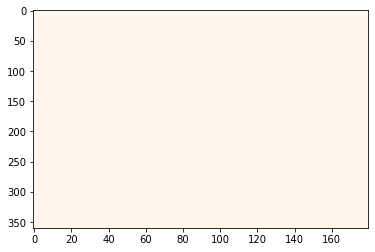

0 0


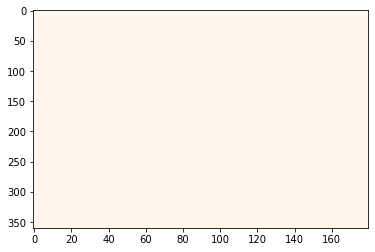

0 0


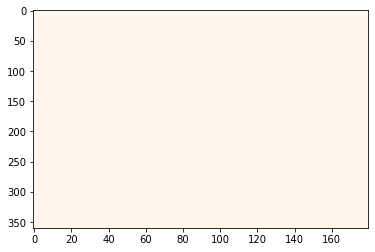

0 0


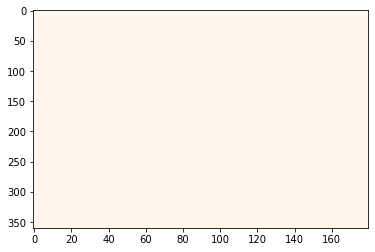

0 0


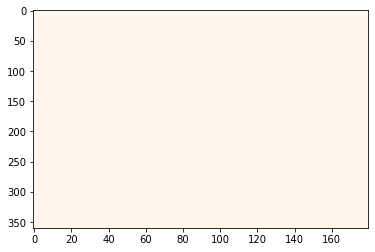

0 0


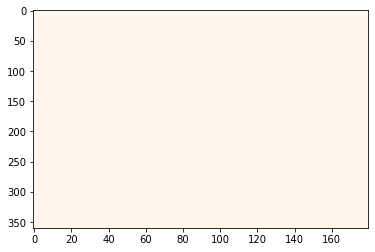

5247 9


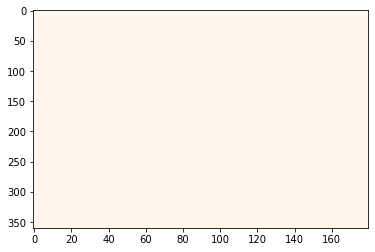

6081 8


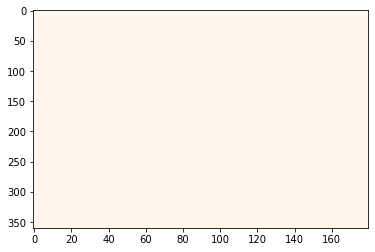

5152 8


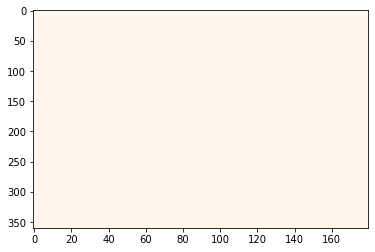

6728 10


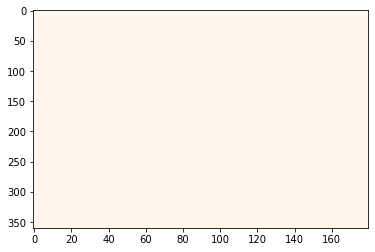

6524 9


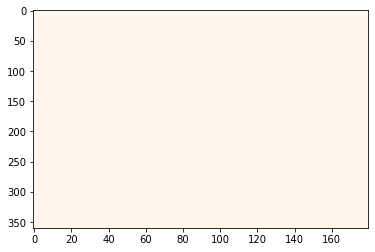

5911 9


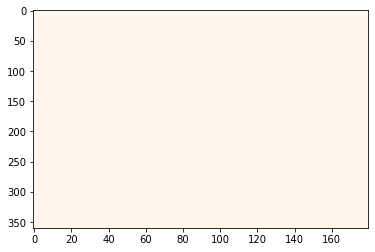

In [6]:
#from tempfile import TemporaryFile
#outfile=TemporaryFile()
#np.save(outfile,OT_map)
#import cartopy
#import cartopy.crs as ccrs
#print(OTA_night.shape,np.mean(OTA_night),np.std(OTA_night))
#print(OTA_day.shape,np.mean(OTA_day),np.std(OTA_day))
#np.savetxt('OT_map_day_2criteria.txt',np.reshape(OT_map[:,:,0],(360,180)),delimiter=',',fmt='%5i')
#np.savetxt('OT_map_night_2criteria.txt',np.reshape(OT_map[:,:,1],(360,180)),delimiter=',',fmt='%5i')
#np.savetxt('OTA_pdf_2criteria.txt',OTA_pdf,delimiter=',')

#n, bins, patches=plt.hist(x=OTA_day,bins=50,color='g')

#plt.hist(x=OTA_night,bins=50,color='r')
#plt.show()
#print(np.max(OT_map))

for i in range(12):
    
    print(np.sum(OT_map[:,:,i,0]),np.max(OT_map[:,:,i,0]))
    p=plt.imshow(np.reshape(OT_map[:,:,2,1],(360,180)),vmin=0,vmax=5,cmap=plt.get_cmap('OrRd'),aspect='auto')
    plt.show()